# **Diffusion Model in Causal Inference with Unmeasured Confounders**
## **Tatsuhiro Shimizu**
## ***AI Lab, CyberAgent Tokyo, Japan***
## **0009-0009-9746-3346**

This is the code for the Example 11. in the main text.
The following image is the SCM that we implement.

- <font color='red'>Unobserved nodes: $X_1, X_4$</font>
- Cause node: $X_2$
- Outcome node: $X_5$
- Node that satisfies the backdoor criterion for a pair $(X_2, X_5)$: $X_3$

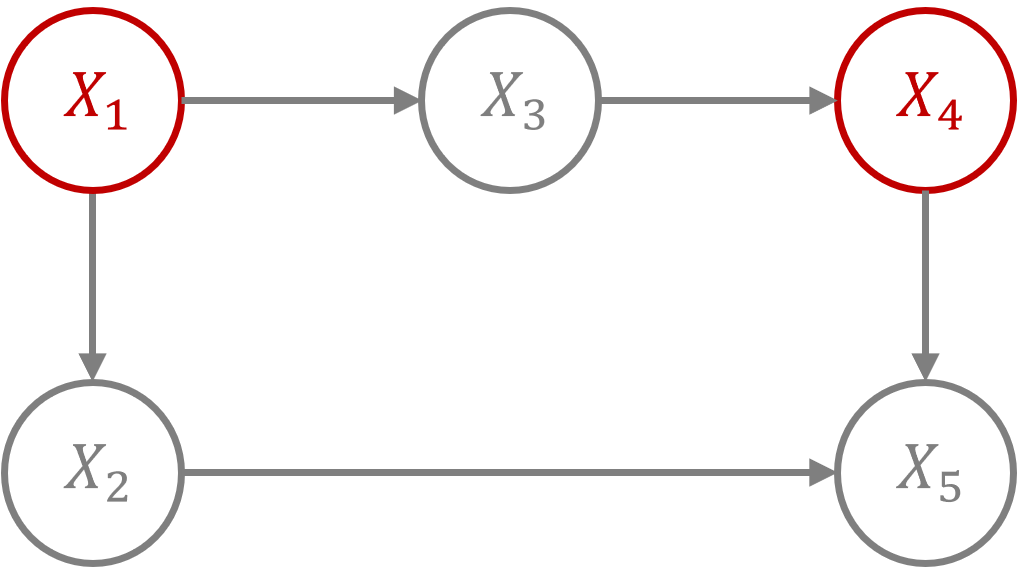

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional
import torch.utils.data

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

plt.style.use('ggplot')

%matplotlib inline


Define
- the number of observation: n_obs = 1000 (same environment as the DCM paper)
- the number of samples from DCM and BDCM: n_sample_DCM = 500 (same environment as the DCM paper)

In [ ]:
# deifne the number of samples in observational data X
# n_obs = 5000 # same number of samples that
n_obs = 1000 # shorter version
# n_obs = 50 # very short version

# Define the number of samples we want to approximate the target
# n_sample_DCM = 1000 # same environment as DCM paper
n_sample_DCM = 500 # shorter version
# n_sample_DCM = 20 # shorter version

## DCM Training

Define
- time: $T = 100$
- noise schedule: $\beta_t$ and $\alpha_t$ for all $i = 1, \cdots, T$

In [ ]:
# Define T, mu, sigma
T = 100
mu = 0
sigma = 1

# Define beta_t
beta_t = (0.1 - 0.0001) * (np.linspace(1, T, T) - 1) / (T - 1) + 0.0001

# Define alpha_t
alpha_t = np.zeros(T)
for i in range(len(beta_t)):
    if i == 0:
        alpha_t[i] = (1 - beta_t[i])
    else:
        alpha_t[i] = (1 - beta_t[i]) * alpha_t[i - 1]


In [ ]:
# Define the function to normalize
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

Define
- the structural equation: $X_i = f(PA(X_i)) + U_i$
  - $X_1 = U_1$
  - $X_2 = \frac{\sqrt{|X_1|} (|U_2| + 0.1)}{2} + |X_1| + \frac{U_2}{5}$
  - $X_3 = \frac{1}{1 + (|U_3| + 0.1) \exp(-X_2)}$
  - $X_4 = X_3 + X_3 U_4 + U_4$
  - $X_5 = X_2 + X_4 + X_2 X_4 U_5 + U_5$
- number of internvened values
- intervened values

Sample
- exogeneous nodes: $U_1, U_2, U_3, U_4, U_5 \sim \mathcal{N}(0, 1)$
- endogenous nodes: $X_1, X_2, X_3, X_4, X_5$
- intervened nodes: $X_5|do(X_2 = x_2)$
- time: $t \sim \mathcal{N}(0, 1)$
- noise: $\epsilon \sim \mathcal{N}(0, 1)$


Define
- epoch: num_epochs = 500
- batch size: batch_size = 64
- learning rate: learning_rate $\eta$ = 0.0001

Neural Network: 3 hidden layers
- 1st layer: 128 nodes
- 2nd layer: 256 nodes
- 3rd layer: 256 nodes

Train the Neural Network

Plot the loss of the training over the epoch

<ipython-input-5-5f26683c8029>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array_list_parent_ind = np.array([[], [1], [1], [3], [2, 4]])
<ipython-input-5-5f26683c8029>:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  parent = np.array([[1], [1, 3]])
<ipython-input-5-5f26683c8029>:427: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  mm

mean of MMD for DCM: 0.00451
standard deviation of MMD for DCM: 0.00254
mean of MMD for BDCM: 0.00163
standard deviation of MMD for BDCM: 0.00117
mean of MMD for DCM: 0.00235
standard deviation of MMD for DCM: 0.00151
mean of MMD for BDCM: 0.00119
standard deviation of MMD for BDCM: 0.000872
mean of MMD for DCM: 0.00139
standard deviation of MMD for DCM: 0.00272
mean of MMD for BDCM: 0.000386
standard deviation of MMD for BDCM: 0.000136
mean of MMD for DCM: 0.00194
standard deviation of MMD for DCM: 0.000833
mean of MMD for BDCM: 0.00092
standard deviation of MMD for BDCM: 0.000593
mean of MMD for DCM: 0.00149
standard deviation of MMD for DCM: 0.000492
mean of MMD for BDCM: 0.00107
standard deviation of MMD for BDCM: 0.000421


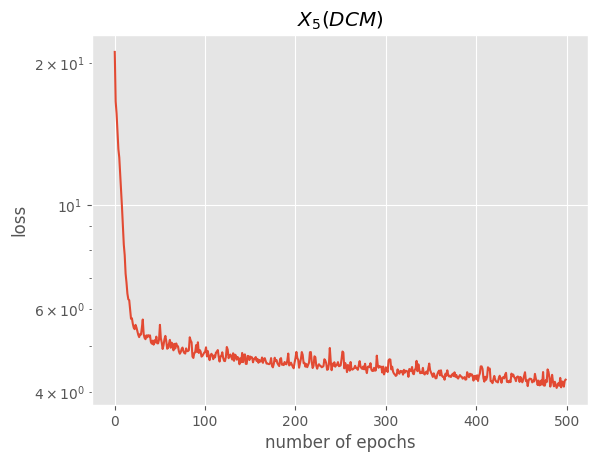

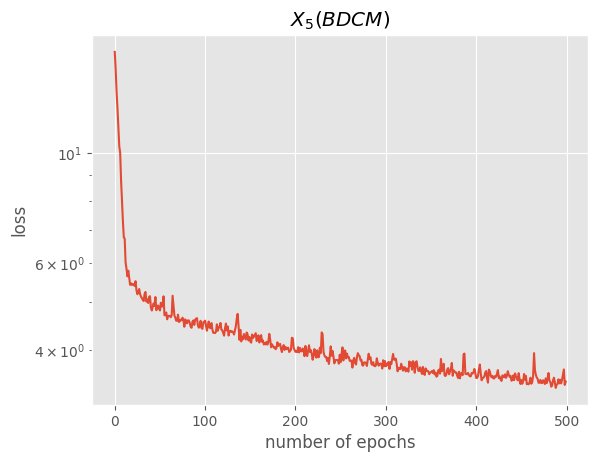

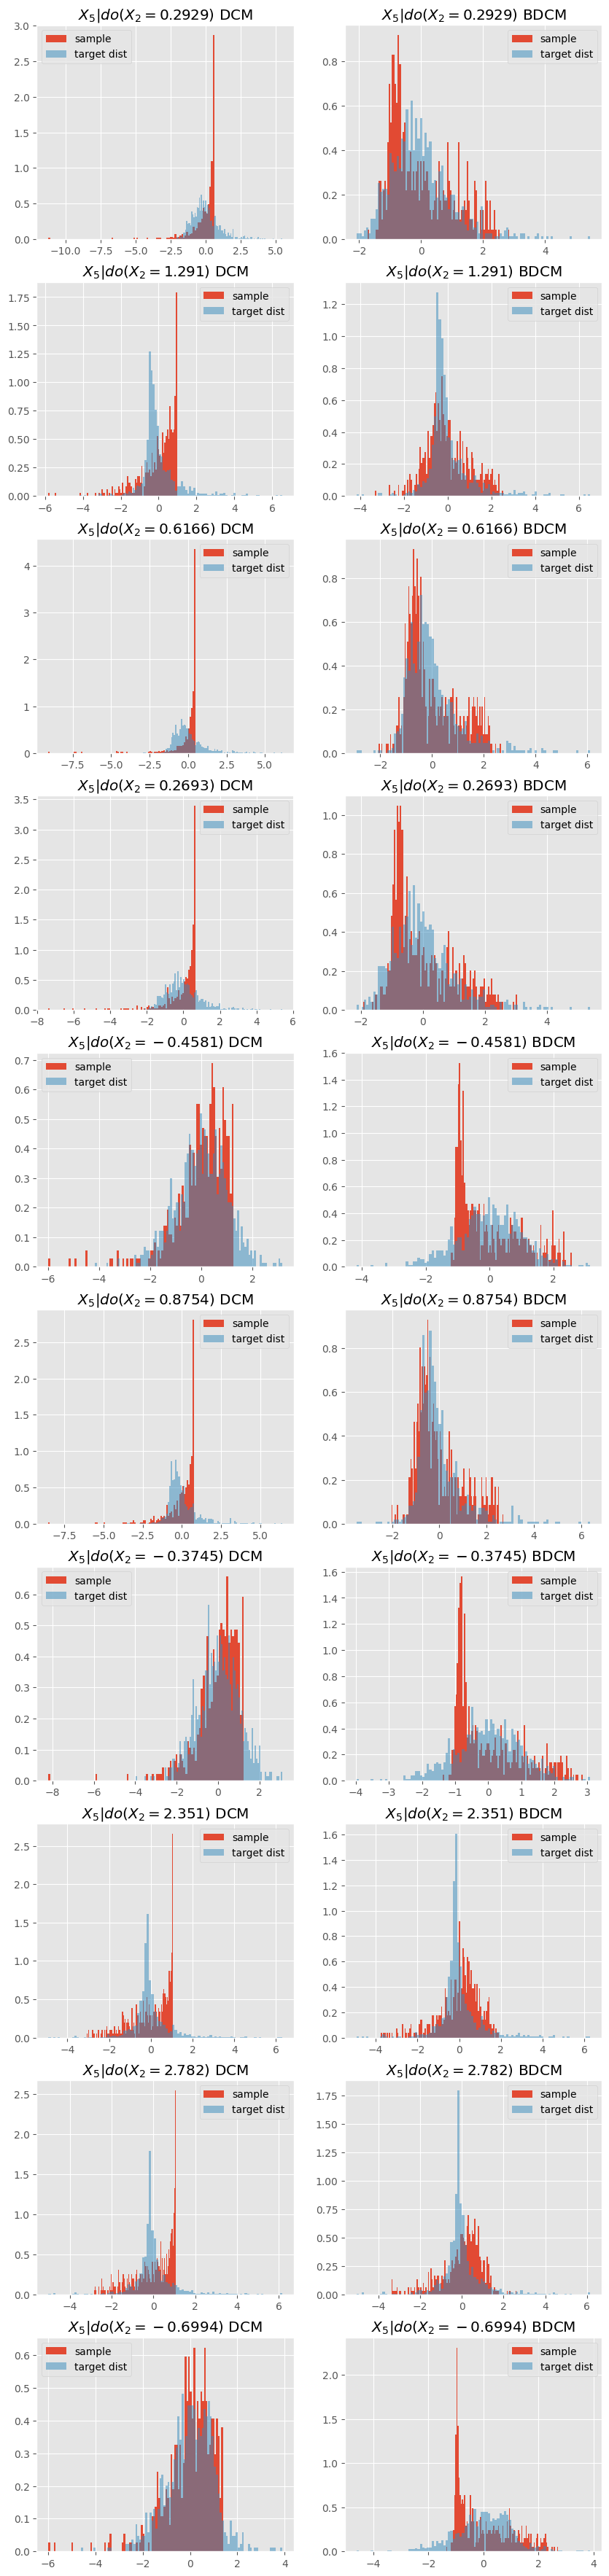

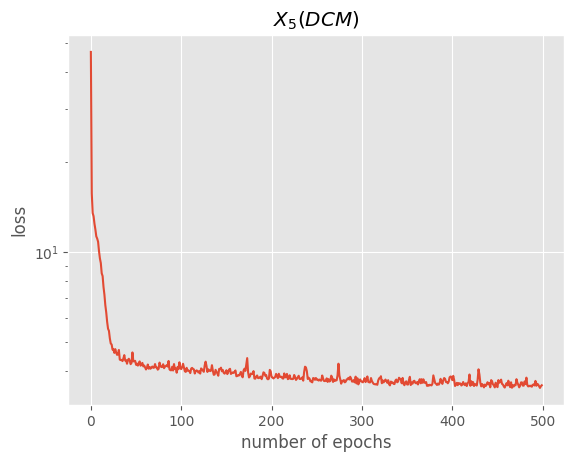

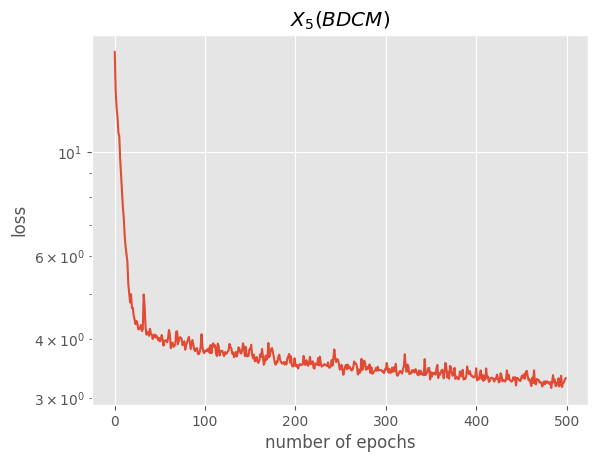

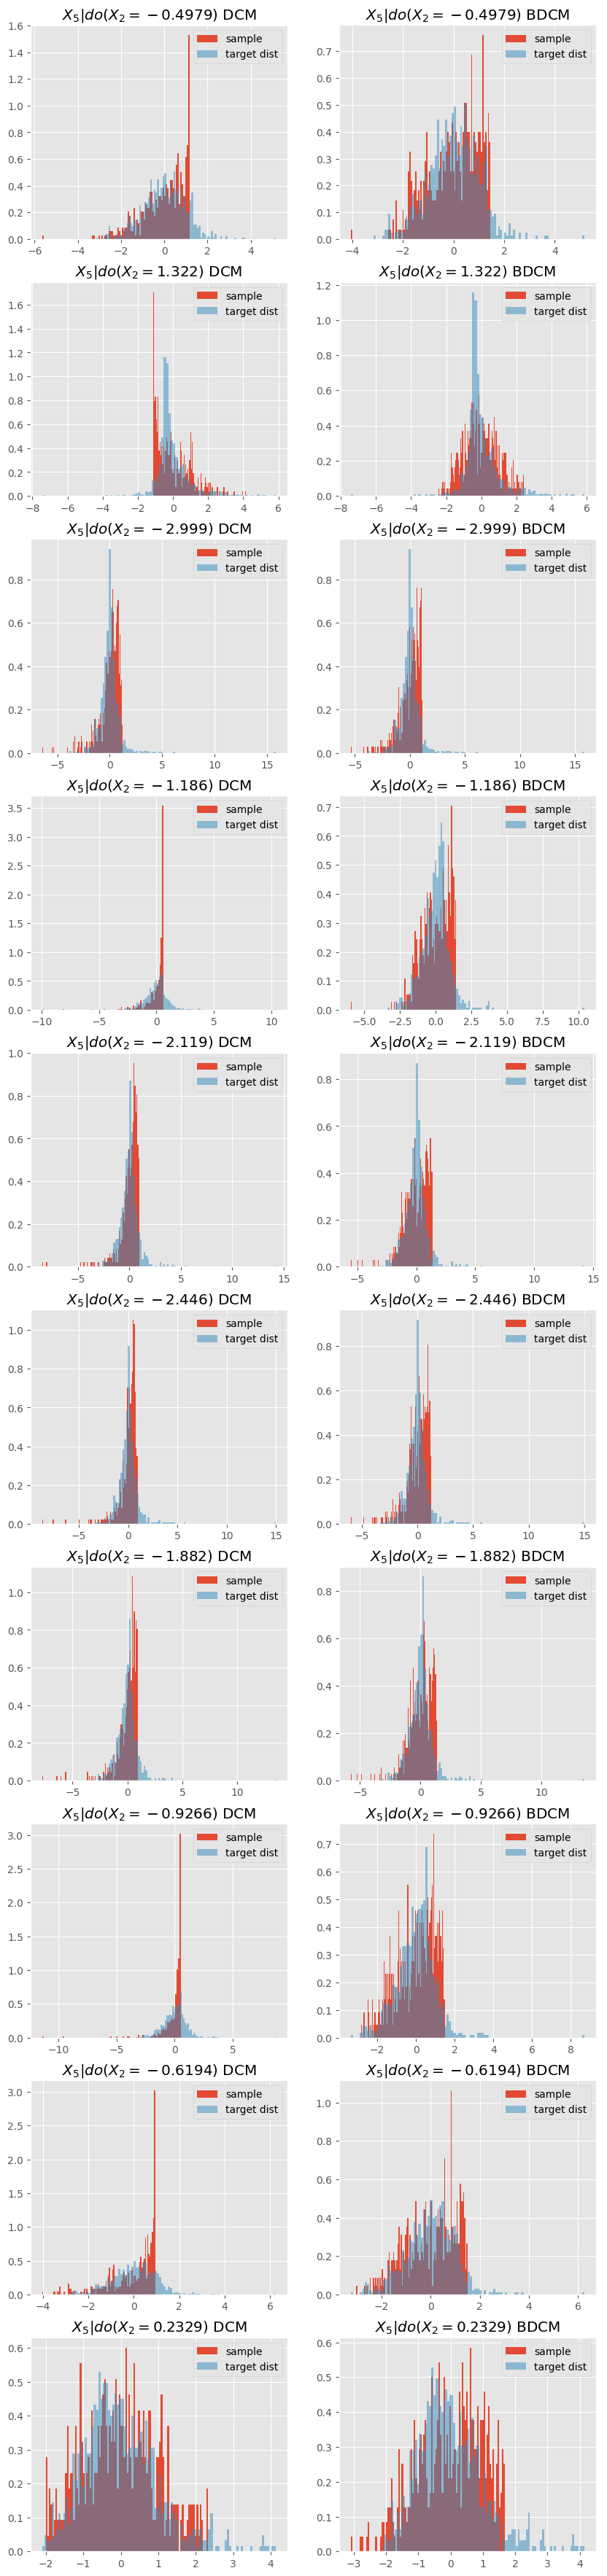

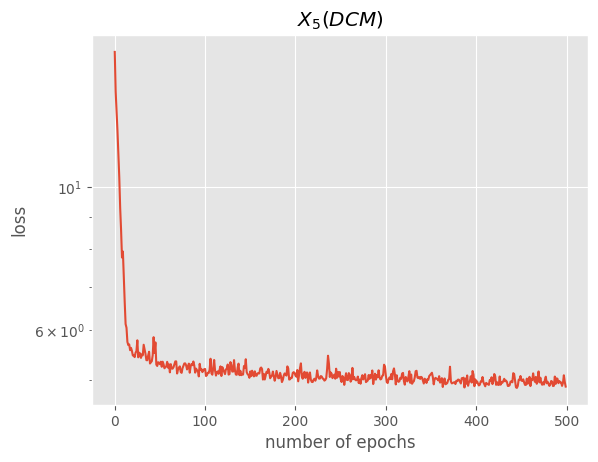

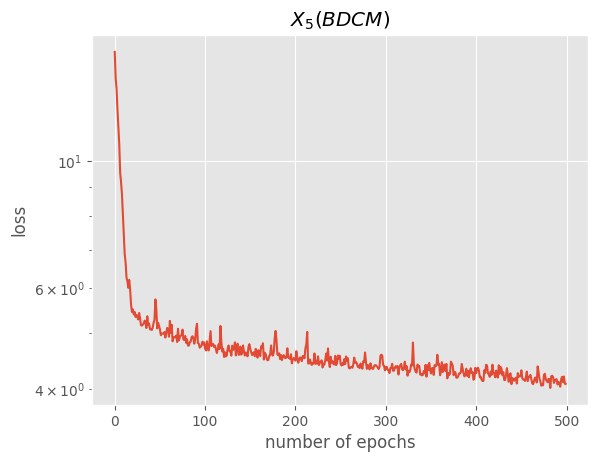

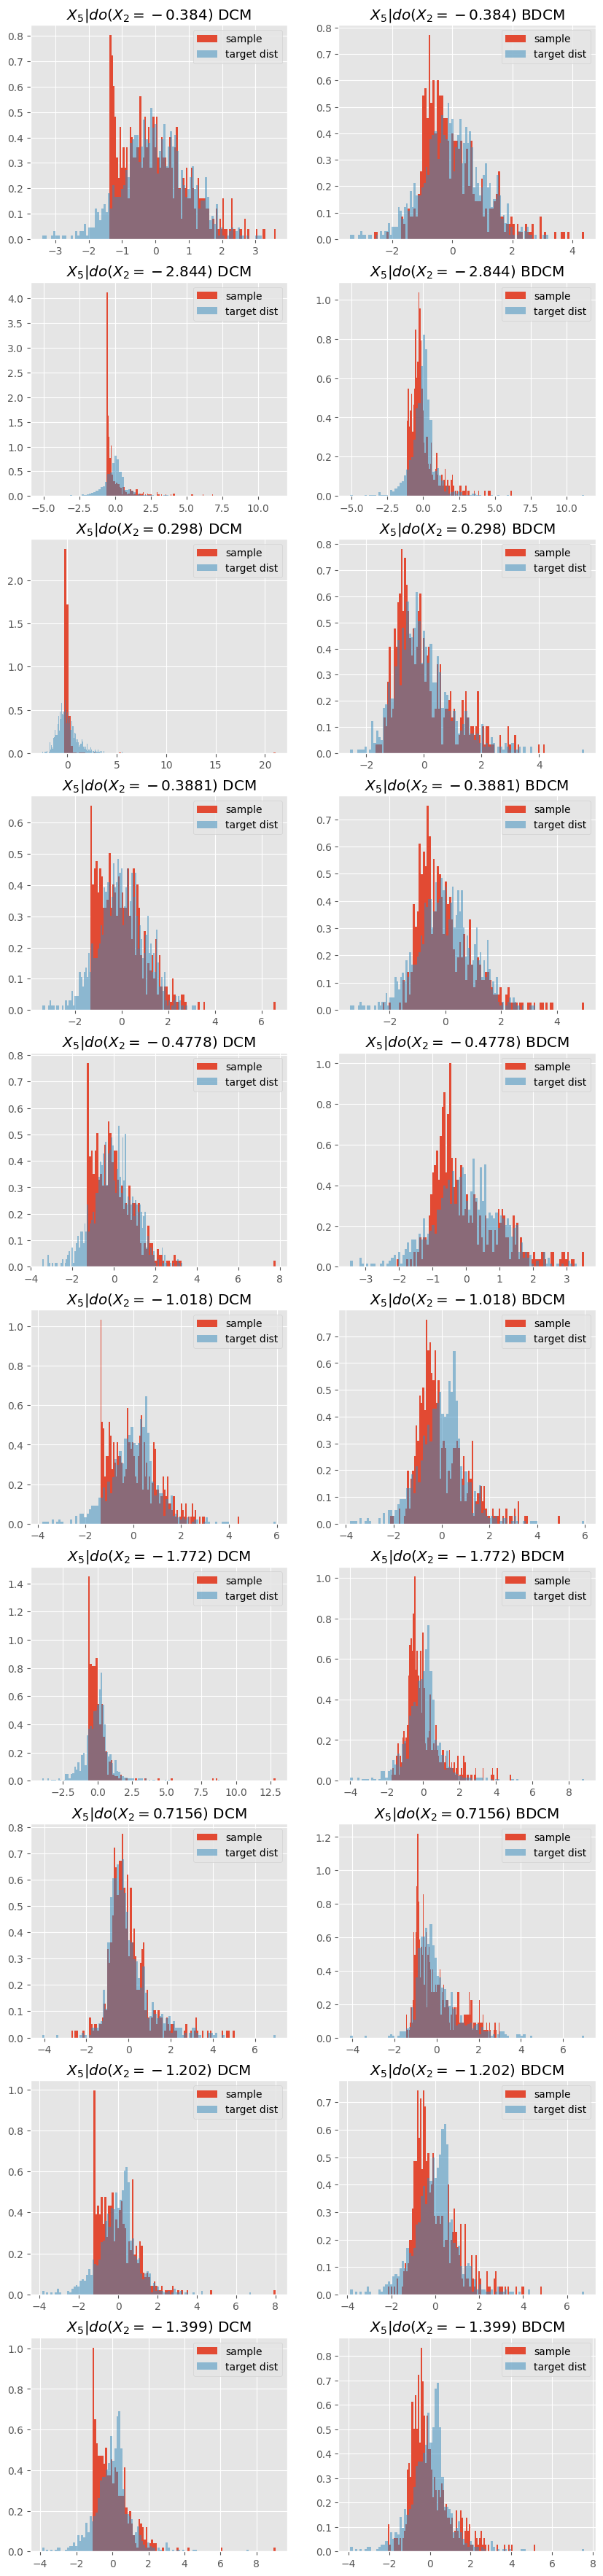

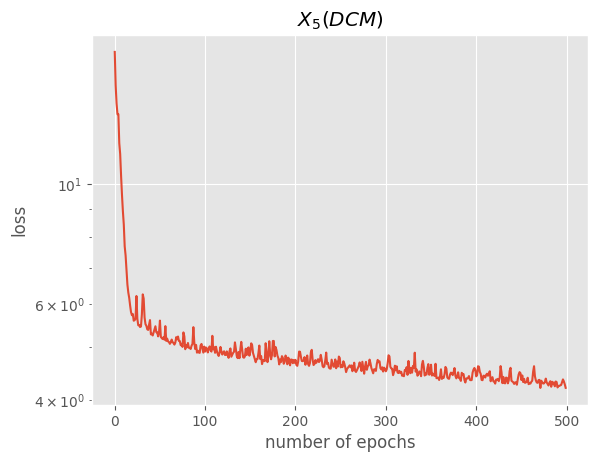

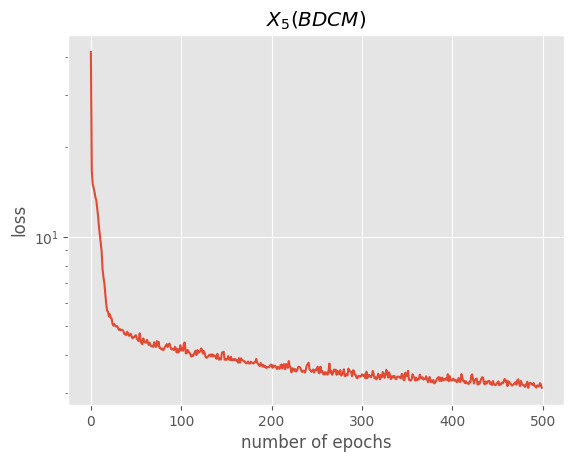

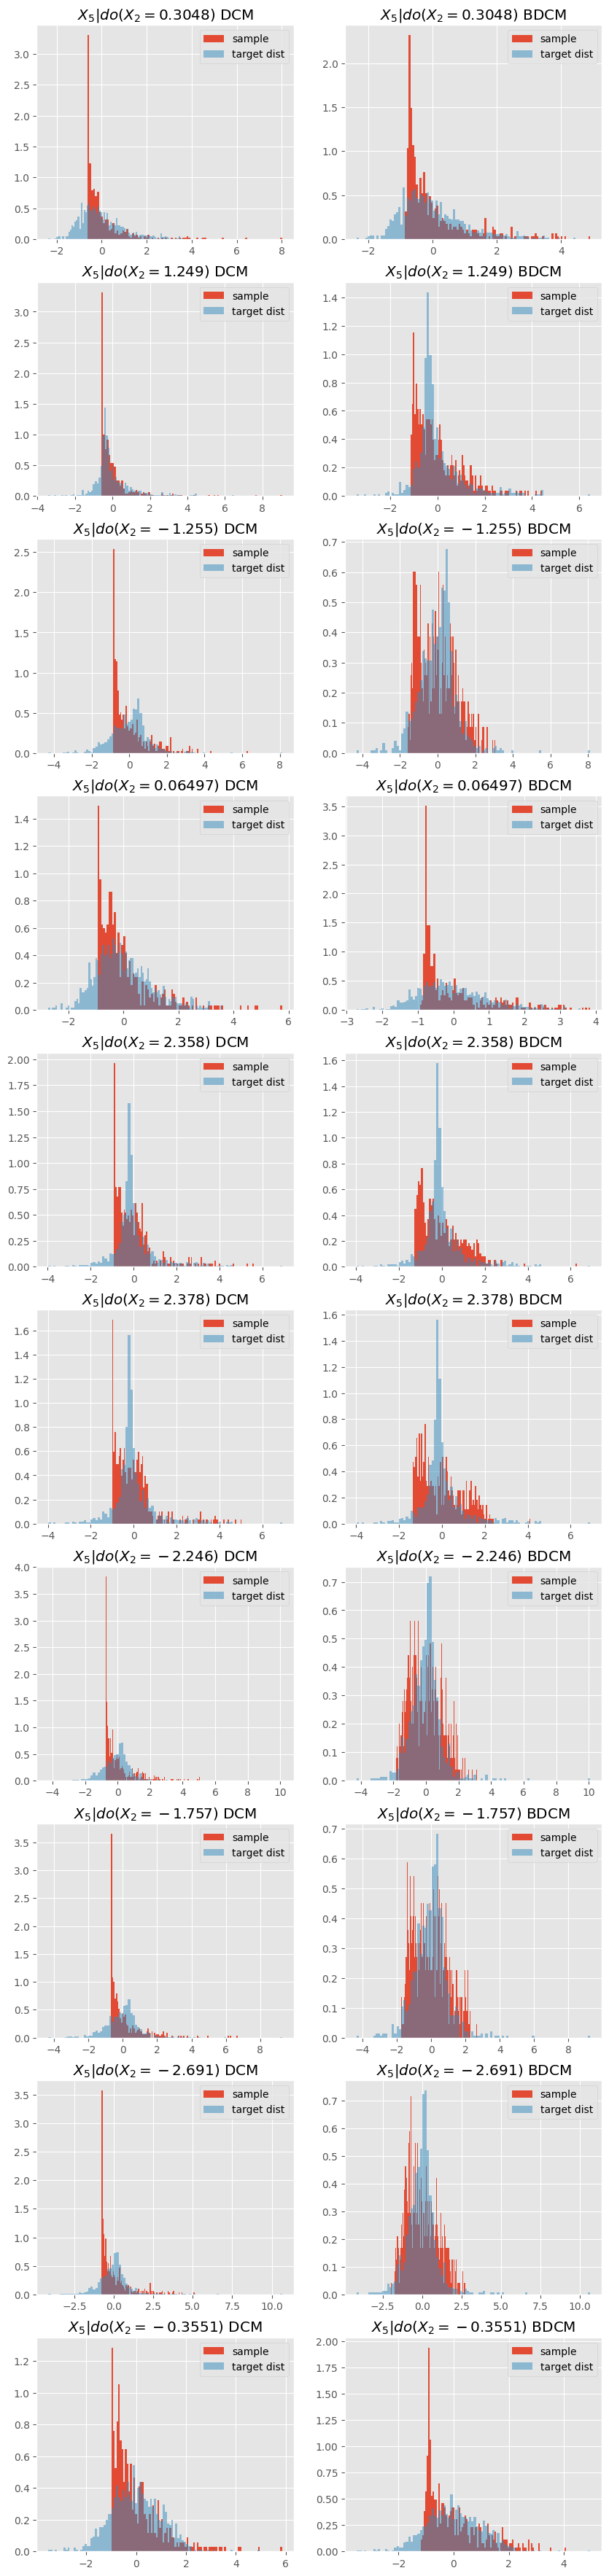

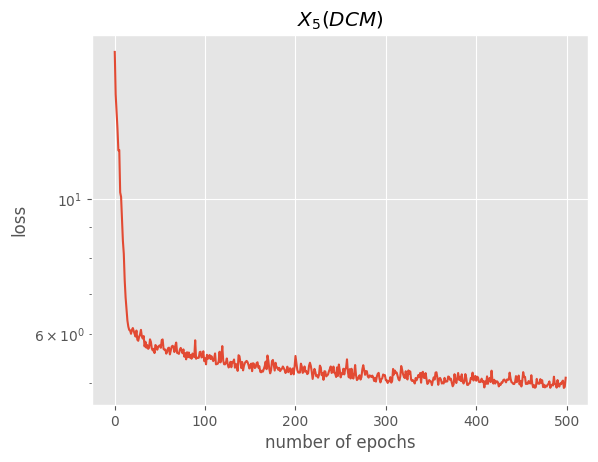

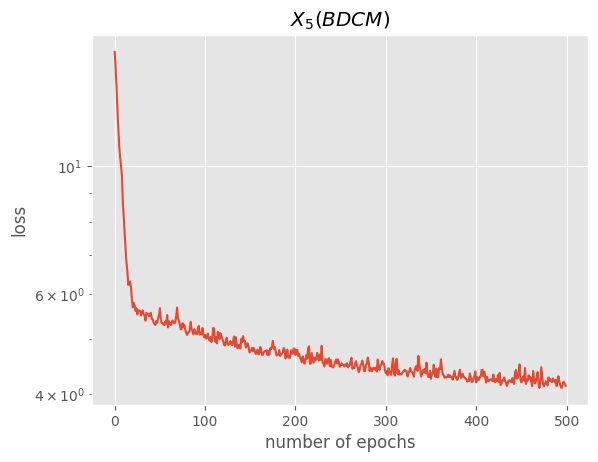

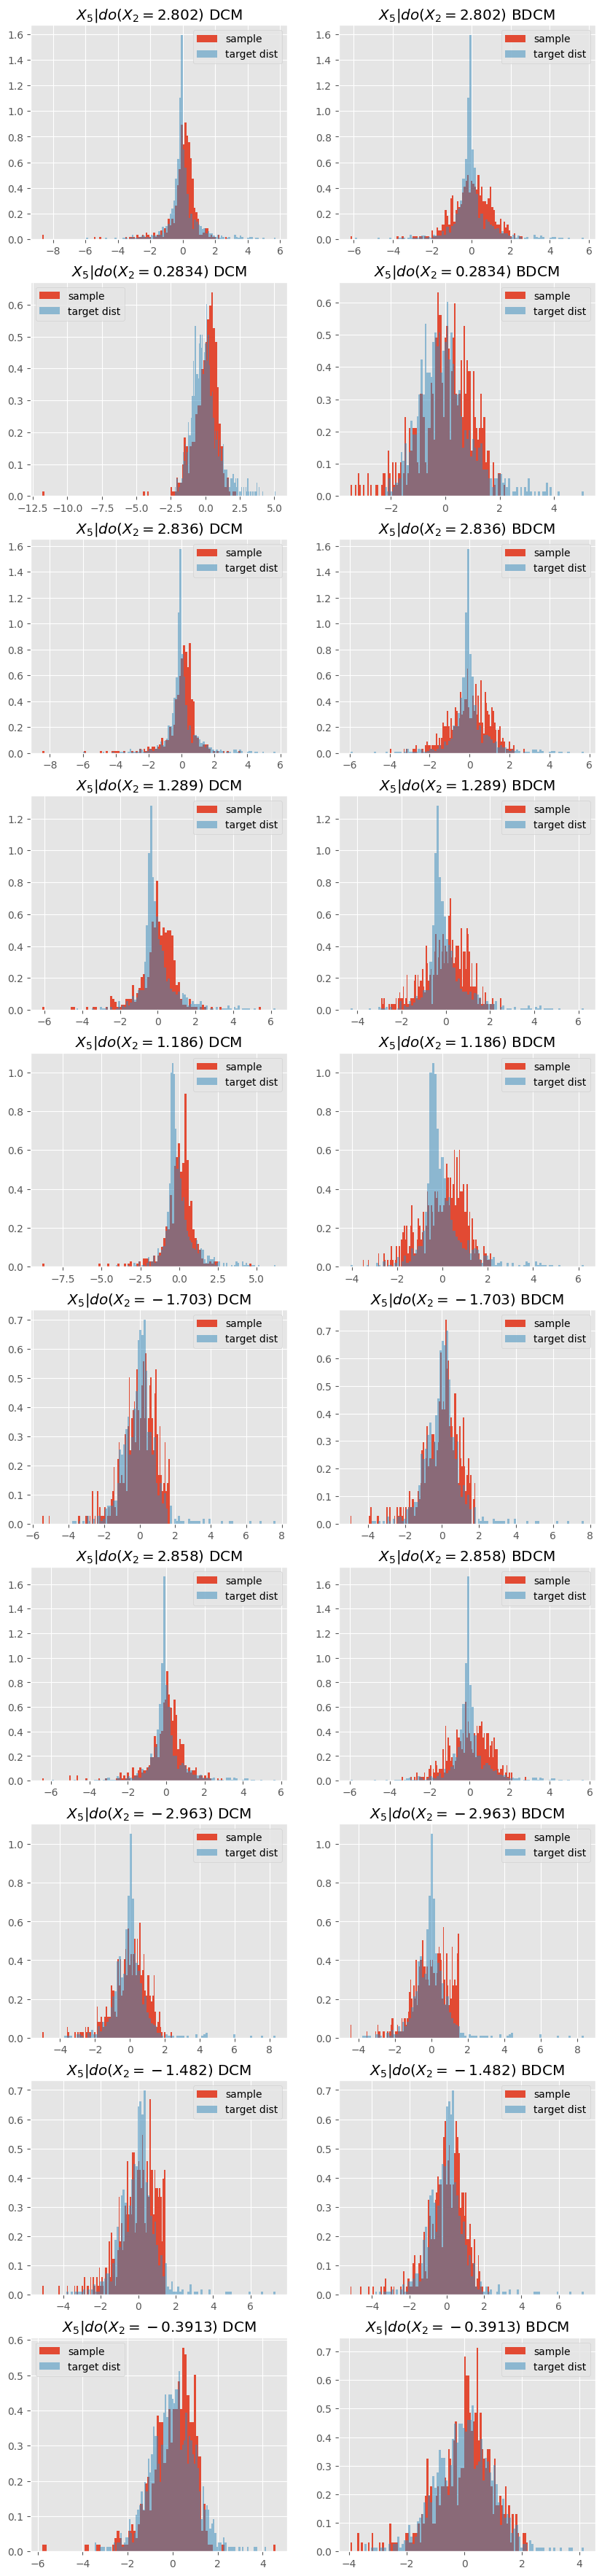

In [ ]:
# Define the number of seeds
num_seeds = 5

# Initialized the array to save the output of each iterations over seeds
array_array_MMD = []

for s in range(num_seeds):
  # Set the seed
  seed_value = s

  # Set random seed for random
  random.seed(seed_value)
  # Set random seed for NumPy
  np.random.seed(seed_value)
  # Set random seed for PyTorch
  torch.manual_seed(seed_value)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed_value)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

  # Define the array of interneved values
  # 10 interventinos with the intervened value ranging from -3 to 3 linearly
  array_interventions = np.random.uniform(-3, 3, 10)


  # Define the number of endogenous or exogenous variables in SCM
  d = 5

  # Sample exogenous nodes U_i ~ N(mu, sigma)
  array_u = np.array([])
  for i in range(d):
    u = np.random.normal(mu, sigma, n_obs)
    if i == 0:
      array_u = u
    else:
      array_u = np.vstack((array_u, u))

  x = np.zeros([d, n_obs])


  # the array of the list of the indexes of the parent node in DAG
  array_list_parent_ind = np.array([[], [1], [1], [3], [2, 4]])

  # Define the structual equation
  # X_i = f_i(X_{pa_i}) + U_i

  def structural_eq(u, ind, x):
    if ind == 0:
      output = u
    elif ind == 1:
      output = np.sqrt(abs(x[0])) * (abs(u) + 0.1) / 2 + abs(x[0]) + u / 5
    elif ind == 2:
      output = 1 / (1 + (abs(u) + 0.1) * np.exp(- x[1]))
    elif ind == 3:
      output = x[2] + x[2] * u + u
    elif ind == 4:
      output = x[1] + x[3] + x[1] * x[3] * u + u
    return normalize(output)

  # Define the function to sample when we intervene in nodes
  def true_sample_x5_do_x2(x2_intervened):
    x_do = np.zeros([d, n_obs])
    x_do[0] = structural_eq(array_u[0], 0, x_do)
    for i in range(n_obs):
      x_do[1][i] = x2_intervened
    x_do[2] = structural_eq(array_u[2], 2, x_do)
    x_do[3] = structural_eq(array_u[3], 3, x_do)
    x_do[4] = structural_eq(array_u[4], 4, x_do)
    return x_do[4]


  # Sample endogenous nodes X_i by the structural equations
  for i in range(d):
    x[i] = structural_eq(array_u[i], i, x)

  # Generate t ~ Unif([T])
  # Generate \epsilon ~ N(mu, sigma)
  t_for_x = np.array([])
  epsilon_for_x = np.array([])
  for i in range(d):
    t = np.array([random.randint(1, T) for x in range(n_obs)])
    epsilon = np.random.normal(mu, sigma, n_obs)
    if i == 0:
      t_for_x = t
      epsilon_for_x = epsilon
    else:
      t_for_x = np.vstack((t_for_x, t))
      epsilon_for_x = np.vstack((epsilon_for_x, epsilon))


  # Get the alpha_t for training
  # Initialize the alpha_t
  alpha_t_train_for_x = np.zeros((d, n_obs))
  for i in range(n_obs):
    for j in range(d):
      alpha_t_train_for_x[j][i] = alpha_t[t_for_x[j][i] - 1]

  # Define the function to create the first input to the neural network
  def create_input_1(alpha_t, x, epsilon):
      return np.sqrt(alpha_t) * x + np.sqrt(1 - alpha_t) * epsilon

  # Create the input for the neural network

  # the nodes for which we use DEC
  array_titles = np.array(["X_5 (DCM)", "X_5 (BDCM)"])

  # Define the array of the index for epsilon for the neural networks (index - 1)
  array_index_for_epsilon = np.array([4, 4])

  # Define the array of the numbers of the inputs for the neural networks (2 + number of parents or adjustment set)
  array_num_input_for_nn = np.array([3, 4])

  # Define the array of the parents or the adjustment set for each DEC (index - 1)
  parent = np.array([[1], [1, 3]])

  # Define the number of neural network
  num_neural_net = len(array_num_input_for_nn)

  # Initialize the input to be used for the training
  array_input_x = []

  # loop for the number of neural network
  for i in range(num_neural_net):
    # First input by using the predefined function
    ind = array_index_for_epsilon[i]
    fisrt_input = create_input_1(alpha_t_train_for_x[ind], x[ind], epsilon_for_x[ind])
    # Concatenate the inputs
    input_x = np.vstack((fisrt_input, x[parent[i]], t_for_x[ind])).T
    array_input_x.append(input_x)

  # define the epoch, batch size, and learning rate
  num_epochs = 500
  batch_size = 64
  learning_rate = 0.0001

  # Define the data class to do mini batch learning
  class MakeDataset(torch.utils.data.Dataset):

      def __init__(self, x, y=None):
          self.x = x
          self.y = y

      def __len__(self):
          return self.x.shape[0]

      def __getitem__(self, i):
          x = torch.from_numpy(self.x[i]).float()
          if self.y is not None:
              y = torch.from_numpy(self.y[i]).float()

          if self.y is not None:
              return x, y
          else:
              return x


  # # Define the nueral network to be used for DCM and BDCM
  # Input: the number of input size
  # Output: the object of neural network
  class Net_x(torch.nn.Module):

    def __init__(self, num_input):
      super(Net_x, self).__init__()
      self.fc1 = torch.nn.Linear(num_input, 128)
      self.fc2 = torch.nn.Linear(128, 256)
      self.fc3 = torch.nn.Linear(256, 256)
      self.fc4 = torch.nn.Linear(256, 1)

    def forward(self, x):
      x = torch.nn.functional.silu(self.fc1(x))
      x = torch.nn.functional.silu(self.fc2(x))
      x = torch.nn.functional.silu(self.fc3(x))
      x = self.fc4(x)
      return x


  # Train the neural network that will be used for the decoding process
  # Initialize the array that save the trained nets and the losses
  array_net_x = np.array([])
  array_epoch_loss = np.array([])

  # loop for the neural net
  for i in range(len(array_input_x)):
    # Prepare dataset
    dataset = MakeDataset(array_input_x[i], epsilon_for_x[array_index_for_epsilon[i]].reshape(-1, 1))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Prepare model and training parameters
    # Instantiate the Neural Network
    net = Net_x(array_num_input_for_nn[i])
    # Chnage the Neural Network to the training mode
    net.train()
    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    # Define the criterion
    criterion = torch.nn.MSELoss()

    # Training
    epoch_loss = []
    for epoch in range(num_epochs):
      # use 'dataloader' to start batch learning
      running_loss = 0   # loss in this epoch
      for inputs, labels in dataloader:
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # add loss of this batch to loss of epoch
          running_loss += loss.data.numpy().tolist()

      epoch_loss.append(running_loss)

    # Append the trained net and loss to the array
    if i == 0:
      array_net_x = net
      array_epoch_loss = epoch_loss
    else:
      array_net_x = np.append(array_net_x, net)
      array_epoch_loss = np.vstack((array_epoch_loss, epoch_loss))

    num_neural_net = len(array_epoch_loss)

  # for loop over the neural network
  for i in range(num_neural_net):
    # Plot the loss over the epoch
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(list(range(len(array_epoch_loss[i]))), array_epoch_loss[i])
    ax.set_xlabel('number of epochs')
    ax.set_ylabel('loss')
    ax.set_yscale('log')
    ax.set_title('${}$'.format(array_titles[i]))
    fig.show()

  # Define the decoder
  # Dec_i(Z_i, X_{pa_i})
  # Input: exogenous node, array of parent nodes, and the index of the order NN was created
  # Output: the last node in the reverse diffusion process
  def DEC(x_parents, index_order):

      # Define the vector that preserves the variables obtained via the reverse diffusion process
      x_hat = np.zeros(T + 1)
      # Initialize the start node of the reverse diffusion process
      x_hat[T] = np.random.normal(0, 1)
      # Save the variables in the reverse diffusion process
      for i in range(1, T + 1):
          t = T + 1 - i

          # Change the network mode to evaluation
          array_net_x[index_order].eval()
          # Define the inputs
          # input_x = np.column_stack((np.array([x_hat[t]]), x_parents.T, np.array([t])))
          input_x = np.append(np.array([x_hat[t]]), x_parents)
          input_x = np.append(input_x, np.array([t]))
          input_x = np.array([input_x])
          # convert the input to tensor
          input_x_tensor = torch.from_numpy(input_x).float()
          # Make prediction
          with torch.no_grad():
              output_x_tensor = array_net_x[index_order](input_x_tensor)
          # Convert the output to numpy data
          output_x = output_x_tensor.data.numpy()
          # Calculate the next variable in the reverse diffusion process by the formula
          x_hat[t - 1] = np.sqrt(alpha_t[t - 2] / alpha_t[t - 1]) * x_hat[t] - output_x[0][0] * (np.sqrt(alpha_t[t - 2] * (1 - alpha_t[t - 1]) / alpha_t[t - 1]) - np.sqrt(1 - alpha_t[t - 2]))
      # Return the last variable in the reverse diffusion process
      return x_hat[0]

  # Define the function to sample X_4 n times when we intervene to X_1 in DCM
  # Input: the number of samples we want to obtain and the value of the intervention
  # Output: the vector of the samples from the target distribution
  def sample_X_outcome_DCM(n_sample_DCM, x2_intervention):
      # Initialize the sample list by just zero vector
      x_outcome_DDIM_list = np.zeros(n_sample_DCM)

      # Iteratively sample from the target distribution
      for i in range(n_sample_DCM):
          # Set X_2 to the intervened value
          x2_sampled = x2_intervention
          x3_sampled = random.choice(x[2])
          # Concatenate the parents and nodes which satisfy the backdoor criterion
          x5_parents = np.array([x2_sampled])
          # Sample X_2 by using the decoder function
          x5_sampled = DEC(x5_parents, 0)
          # Add the sampled value to the list
          x_outcome_DDIM_list[i] = x5_sampled

      return x_outcome_DDIM_list


  # Define the function to sample X_4 n times when we intervene to X_1 in BDCM
  # Input: the number of samples we want to obtain and the value of the intervention
  # Output: the vector of the samples from the target distribution
  def sample_X_outcome_BDCM(n_sample_DCM, x2_intervention):
      # Initialize the sample list by just zero vector
      x_outcome_DDIM_list = np.zeros(n_sample_DCM)

      # Iteratively sample from the target distribution
      for i in range(n_sample_DCM):
          # Set X_2 to the intervened value
          x2_sampled = x2_intervention
          x3_sampled = random.choice(x[2])
          # Concatenate the parents and nodes which satisfy the backdoor criterion
          x5_parents = np.array([x2_sampled, x3_sampled])
          # Sample X_2 by using the decoder function
          x5_sampled = DEC(x5_parents, 1)
          # Add the sampled value to the list
          x_outcome_DDIM_list[i] = x5_sampled

      return x_outcome_DDIM_list


  def sample_outcome_do_cause_DCM(x2):
    # sample from the target when we intervene by do(X2 = x2)
    return sample_X_outcome_DCM(n_sample_DCM, x2)

  def sample_outcome_do_cause_BDCM(x2):
    # sample from the target when we intervene by do(X2 = x2)
    return sample_X_outcome_BDCM(n_sample_DCM, x2)

  # Define MMD function
  import torch
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  def MMD(x, y, kernel):
      """Emprical maximum mean discrepancy. The lower the result
        the more evidence that distributions are the same.

      Args:
          x: first sample, distribution P
          y: second sample, distribution Q
          kernel: kernel type such as "multiscale" or "rbf"
      """
      xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
      rx = (xx.diag().unsqueeze(0).expand_as(xx))
      ry = (yy.diag().unsqueeze(0).expand_as(yy))

      dxx = rx.t() + rx - 2. * xx # Used for A in (1)
      dyy = ry.t() + ry - 2. * yy # Used for B in (1)
      dxy = rx.t() + ry - 2. * zz # Used for C in (1)

      XX, YY, XY = (torch.zeros(xx.shape).to(device),
                    torch.zeros(xx.shape).to(device),
                    torch.zeros(xx.shape).to(device))

      if kernel == "multiscale":

          bandwidth_range = [0.2, 0.5, 0.9, 1.3]
          for a in bandwidth_range:
              XX += a**2 * (a**2 + dxx)**-1
              YY += a**2 * (a**2 + dyy)**-1
              XY += a**2 * (a**2 + dxy)**-1

      if kernel == "rbf":

          bandwidth_range = [10, 15, 20, 50]
          for a in bandwidth_range:
              XX += torch.exp(-0.5*dxx/a)
              YY += torch.exp(-0.5*dyy/a)
              XY += torch.exp(-0.5*dxy/a)

      return torch.mean(XX + YY - 2. * XY)




  # Create the array that save the intervened value, samples from DCM, samples from BDCM
  # Input: array of intervened values
  # Output: DCM and BDCM samples
  def save_array(array_interventions):
    # Get the number of interventions
    num_intervention = np.size(array_interventions)

    # Initialize the array of samples for DCM and BDCM
    array_DCM_samples = np.array([])
    array_BDCM_samples = np.array([])

    # for each intervention
    for i in range(num_intervention):
      if np.any(array_DCM_samples) == False:
        # Plot the empirical distribution of DCM and true target
        array_DCM_samples = np.append(array_DCM_samples, np.array([sample_outcome_do_cause_DCM(array_interventions[i])]))
        # Plot the empirical distribution of BDCM and true target
        array_BDCM_samples = np.append(array_BDCM_samples, np.array([sample_outcome_do_cause_BDCM(array_interventions[i])]))
      else:
        # Plot the empirical distribution of DCM and true target
        array_DCM_samples = np.vstack((array_DCM_samples, np.array([sample_outcome_do_cause_DCM(array_interventions[i])])))
        # Plot the empirical distribution of BDCM and true target
        array_BDCM_samples = np.vstack((array_BDCM_samples, np.array([sample_outcome_do_cause_BDCM(array_interventions[i])])))
      array_array_DCM_BDCM_samples = np.array([array_DCM_samples, array_BDCM_samples])

    return array_array_DCM_BDCM_samples

  # Get the samples from DCM and BDCM
  array_array_DCM_BDCM_samples = save_array(array_interventions)


  # Calculate the number of intervention values
  num_interventions = np.size(array_interventions)

  # Show all the graphs and output MMD where we do(X_1 = x_1)
  figure, axis = plt.subplots(num_interventions, 2, figsize=(10, 4.5 * num_interventions))

  # Initialized the array that saves the values of MMD for DCM and BDCM
  array_MMD_DCM = np.array([])
  array_MMD_BDCM = np.array([])

  array_title = ["DCM", "BDCM"]

  array_MMD_DCM_BDCM = np.zeros([2, num_interventions])

  # for loop for each intervened value
  for i in range(num_interventions):
    # Get the intervened value
    x2_internvened = array_interventions[i]
    # for loop for DCM or BDCM
    for j in range(2):
      # do(X_1 = x_1)
      # Plot samples from DCM or BDCM
      axis[i][j].hist(normalize(array_array_DCM_BDCM_samples[j][i]), 100, density = True, label = "sample")
      # Plot ground truth samples
      axis[i][j].hist(normalize(true_sample_x5_do_x2(x2_internvened)), 100, density = True, alpha = 0.5, label = "target dist")
      axis[i][j].set_title("$X_5|do(X_2 = {:.4})$ {}".format(x2_internvened, array_title[j]))
      axis[i][j].legend()
      # Calculate MMD
      mmd_value = MMD(torch.tensor([normalize(array_array_DCM_BDCM_samples[j][i])]).T.to(device), torch.tensor([normalize(true_sample_x5_do_x2(x2_internvened))[:n_sample_DCM]]).T.to(device), "rbf")
      array_MMD_DCM_BDCM[j][i] = mmd_value.item()

  # Output the mean and standard deviation of MMD for DCM and BDCM
  # loop for DCM or BDCM
  for i in range(2):
      print("mean of MMD for {}: {:.3}".format(array_title[i], np.mean(array_MMD_DCM_BDCM[i])))
      print("standard deviation of MMD for {}: {:.3}".format(array_title[i], np.std(array_MMD_DCM_BDCM[i])))

  array_array_MMD.append(array_MMD_DCM_BDCM)



In [ ]:
all_MMD_DCM = np.array([])
all_MMD_BDCM = np.array([])
for i in range(num_seeds):
  all_MMD_DCM = np.append(all_MMD_DCM, array_array_MMD[i][0])
  all_MMD_BDCM = np.append(all_MMD_BDCM, array_array_MMD[i][1])

all_MMD_DCM_BDCM = [all_MMD_DCM, all_MMD_BDCM]
# Output the mean and standard deviation of MMD for DCM and BDCM
# loop for DCM or BDCM
for i in range(2):
    print("mean of all MMD for {}: {:.3}".format(array_title[i], np.mean(all_MMD_DCM_BDCM[i])))
    print("standard deviation of all MMD for {}: {:.3}".format(array_title[i], np.std(all_MMD_DCM_BDCM[i])))


mean of all MMD for DCM: 0.00234
standard deviation of all MMD for DCM: 0.00217
mean of all MMD for BDCM: 0.00104
standard deviation of all MMD for BDCM: 0.000835
